In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! git clone https://github.com/simson0524/vae_study.git
%cd vae_study

Cloning into 'vae_study'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 70 (delta 33), reused 50 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 1.18 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/vae_study


### 1. 모델 정의

MNIST를 입력으로 하는 (BATCH, 28*28)

2D Conv Encoder & Decoder로 이루어진 ConvVAE, ConvAE와

Linear Encoder & Decoder로 이루어진 FlattenVAE, FlattenAE 정의

In [3]:
# src/model.py

import torch.nn.functional as F
import torch.nn as nn
import torch

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()

        # 2D-Conv Encoder (shape : [Batches, channels, image(h), image(w)])
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='zeros'
                ), # shape : (B, 1, 28, 28) -> (B, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='zeros'
                ), # shape : (B, 16, 14, 14) -> (B, 64, 7, 7)
            nn.ReLU()
        )

        # avg of Latent vecs (shape : [Batches, latent_dim])
        self.fc_mu = nn.Linear(
                        in_features=64*7*7,
                        out_features=latent_dim
                        )

        # ln(variance) of Latent vecs (shape: [Batches, latent_dim])
        self.fc_logvar = nn.Linear(
                            in_features=64*7*7,
                            out_features=latent_dim
                            )

        # 2D-Conv Decoder (shape : [Batches, ...SAME SHAPE WITH ORIGINAL DATA...])
        self.fc_decoder = nn.Linear(
                                in_features=latent_dim,
                                out_features=64*7*7
                                )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=16,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='zeros'
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=16,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='zeros'
            ),
            nn.Sigmoid()
        )

        # Params Init(Xavier uniform initialization)
        self._init_weights()


    def encode(self, x):
        encoded_x = self.encoder(x)
        encoded_x_flatten = encoded_x.reshape(encoded_x.size(0), -1) # shape : (Batches, flatten_len of sample)
        return self.fc_mu(encoded_x_flatten), self.fc_logvar(encoded_x_flatten)


    def reparameterize(self, mu, logvar):
        std_dev = torch.exp(0.5 * logvar) # standard deviation of Latent vecs
        eps = torch.randn_like(std_dev)

        return mu + eps * std_dev


    def decode(self, latent_z):
        preprocessed_z_in_2d = self.fc_decoder(latent_z).view(-1, 64, 7, 7) # shape : (Batches, 64, 7, 7)

        return self.decoder(preprocessed_z_in_2d)


    def forward(self, x):
        mu, logvar = self.encode(x)
        latent_z = self.reparameterize(mu, logvar)
        reconst_x = self.decode(latent_z)

        return reconst_x, mu, logvar, latent_z


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)



class FlattenVAE(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()

        # Linear Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # avg of Latent vecs
        self.fc_mu = nn.Linear(128, latent_dim)

        # ln(variance) of Latent vecs
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Linear Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

        # Params Init(Xavier uniform initialization)
        self._init_weights()


    def encode(self, x):
        encoded_x = self.encoder(x)

        return self.fc_mu(encoded_x), self.fc_logvar(encoded_x)


    def reparameterize(self, mu, logvar):
        std_dev = torch.exp(0.5 * logvar) # standard deviation of Latent vecs
        eps = torch.randn_like(std_dev)

        return mu + eps * std_dev


    def decode(self, latent_z):
        decoded_x = self.decoder(latent_z)

        return decoded_x.view(-1, 1, 28, 28)


    def forward(self, x):
        mu, logvar = self.encode(x)
        latent_z = self.reparameterize(mu, logvar)
        reconst_x = self.decode(latent_z)

        return reconst_x, mu, logvar, latent_z


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear,)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)



class ConvAE(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()

        # 2D-Conv Encoder (shape : [Batches, channels, image(h), image(w)])
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='zeros'
                ), # shape : (B, 1, 28, 28) -> (B, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='zeros'
                ), # shape : (B, 16, 14, 14) -> (B, 64, 7, 7)
            nn.ReLU()
        )

        # Latent vecs (shape : [Batches, latent_dim])
        self.fc_z = nn.Linear(
                        in_features=64*7*7,
                        out_features=latent_dim
                        )

        # 2D-Conv Decoder (shape : [Batches, ...SAME SHAPE WITH ORIGINAL DATA...])
        self.fc_decoder = nn.Linear(
                                in_features=latent_dim,
                                out_features=64*7*7
                                )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=16,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='zeros'
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=16,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='zeros'
            ),
            nn.Sigmoid()
        )

        # Params Init(Xavier uniform initialization)
        self._init_weights()


    def encode(self, x):
        encoded_x = self.encoder(x)
        encoded_x_flatten = encoded_x.reshape(encoded_x.size(0), -1) # shape : (Batches, flatten_len of sample)

        return self.fc_z(encoded_x_flatten)


    def decode(self, latent_z):
        preprocessed_z_in_2d = self.fc_decoder(latent_z).view(-1, 64, 7, 7) # shape : (Batches, 64, 7, 7)

        return self.decoder(preprocessed_z_in_2d)


    def forward(self, x):
        latent_z = self.encode(x)
        reconst_x = self.decode(latent_z)

        return reconst_x, None, None, latent_z


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)



class FlattenAE(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()

        # Linear Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Linear Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

        # Params Init(Xavier uniform initialization)
        self._init_weights()


    def encode(self, x):
        return self.encoder(x)


    def decode(self, latent_z):
        decoded_x = self.decoder(latent_z)
        return decoded_x.view(-1, 1, 28, 28)


    def forward(self, x):
        latent_z = self.encode(x)
        reconst_x = self.decode(latent_z)

        return reconst_x, None, None, latent_z


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear,)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

### 2. Loss function 정의

입력 데이터 x와 복원 데이터 reconst_x 사이의 차이를 계산하여 모델이 데이터를 얼마나 잘 복원했는지(BCE 재구성 손실 계산, 데이터 충실도)

잠재 공간 분포를 정규 분포와 얼마나 가깝게 유지했는지(KL Divergence 손실 계산, 규제)

를 ${\beta}$를 조절(${\beta}$스케줄링)하며 KL항의 영향력을 학습 진행에 따라 조정할 수 있는 Loss Function 정의


한줄요약 : 모델로 하여금 "원본이미지를 충실히 복원하렴" + "잠재 변수 분포 정규화 시 균형도 충실히 맞추렴"을 주문

In [4]:
# src/loss.py

import torch.nn.functional as F
import torch
import math

def reconst_loss(reconst_x, x):
    loss = F.binary_cross_entropy(reconst_x, x, reduction='sum')

    return loss / x.size(0) # sum of BCE loss / batch_size


def kl_divergence(mu, logvar):
    kl = -0.5 * torch.sum( 1+logvar-mu.pow(2)-logvar.exp() )

    return kl / mu.size(0) # sum of KLD / batch_size


def beta(config, epoch):
    if config['beta_schedule']['type'] == 'linear':
        t = min(1.0, epoch/max(1, config['beta_schedule']['warmup_epochs']))

        return 1.0 + t*(config['beta_schedule']['max_beta']-1.0)

    elif config['beta_schedule']['type'] == 'cosine':
        T = max(1.0, config['beta_schedule']['warmup_epochs'])
        t = min(1.0, epoch / T)

        return 1.0 + 0.5*(1-math.cos(math.pi * t))*(config['beta_schedule']['max_beta'] - 1.0)

    return config['model']['beta']

[참고] BCE + ${\beta\cdot}$ KLD는 이후 vae_train의 학습과정 중 구현

### 3. MNIST 데이터셋 준비하기

MNIST 데이터셋을 각각 Train, Test용 DataLoader로 준비

In [5]:
# src/dataset.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

def get_loaders(root, name="MNIST", batch_size=128, num_workers=0):
    tfm = transforms.ToTensor()
    dataset = datasets.MNIST if name=="MNIST" else datasets.FashionMNIST
    train = dataset(root, train=True, download=True, transform=tfm)
    test  = dataset(root, train=False, download=True, transform=tfm)

    train_loader= DataLoader(
        dataset=train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        dataset=test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

### 4. 학습

제곧내(학습 돌릴거 소스코드임)

In [6]:
# src/utils.py

import random
import torch
import yaml
import os

def load_config(path="config/default.yaml"):
    with open(path) as f:
        return yaml.safe_load(f)

def set_seed(seed=42):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

In [7]:
# src/vae_train.py

from tqdm.auto import tqdm
import torch
import os

def vae_train(model, train_loader, test_loader, config, device="cuda"):
    model.train()

    device = torch.device(config['device'])
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['train']['lr'])

    out_dir = config['paths']['out_dir']
    os.makedirs(out_dir, exist_ok=True)

    for epoch in range(1, config['train']['epochs']+1):
        total = 0
        reconst_total = 0
        for x, _ in tqdm(train_loader, total=len(train_loader), desc=f"[EPOCH {epoch}] Training..."):
            x = x.to(device)
            # forward
            reconst_x, mu, logvar, latent_z = model(x)

            # loss
            reconst_loss_term = reconst_loss(reconst_x, x)
            beta_term = beta(config, epoch)
            kl_divergence_term = kl_divergence(mu, logvar)
            loss = reconst_loss_term + beta_term*kl_divergence_term

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += loss.item()
            reconst_total += reconst_loss_term.item()

        print(f"[EPOCH {epoch}] loss={total/len(train_loader):.4f} (beta={beta_term:.2f})")
        print(f"[EPOCH {epoch}] reconst_loss={reconst_total/len(train_loader):.4f} (beta={beta_term:.2f})\n")


def ae_train(model, train_loader, test_loader, config, device="cuda"):
    model.train()

    device = torch.device(config['device'])
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['train']['lr'])

    out_dir = config['paths']['out_dir']
    os.makedirs(out_dir, exist_ok=True)

    for epoch in range(1, config['train']['epochs']+1):
        total = 0
        for x, _ in tqdm(train_loader, total=len(train_loader), desc=f"[EPOCH {epoch}] Training..."):
            x = x.to(device)
            # forward
            reconst_x, _, _, latent_z = model(x)

            # loss
            loss = reconst_loss(reconst_x, x)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += loss.item()

        print(f"[EPOCH {epoch}] loss={total/len(train_loader):.4f}")

In [9]:
import argparse
import sys
from pathlib import Path

def parse_args(argv=None):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="config/config.yaml")
    args, _ = parser.parse_known_args(argv)
    return args

args = parse_args(sys.argv[1:])
cfg_path = Path(args.config).expanduser().resolve()
config = load_config(str(cfg_path))

set_seed(config['seed'])

train_loader, test_loader = get_loaders(
    root=config['data']['root'],
    name=config['data']['name'],
    batch_size=config['train']['batch_size'],
num_workers=config['train']['num_workers'],
)

vae_model = ConvVAE(latent_dim=config['model']['latent_dim'])
vae_train(vae_model, train_loader, test_loader, config)

# ae_model = ConvAE(latent_dim=config['model']['latent_dim'])
# ae_train(ae_model, train_loader, test_loader, config)

[EPOCH 1] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 1] loss=159.1363 (beta=1.02)
[EPOCH 1] reconst_loss=152.3264 (beta=1.02)



[EPOCH 2] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 2] loss=149.4972 (beta=1.05)
[EPOCH 2] reconst_loss=142.0249 (beta=1.05)



[EPOCH 3] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 3] loss=147.6512 (beta=1.07)
[EPOCH 3] reconst_loss=139.8443 (beta=1.07)



[EPOCH 4] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 4] loss=146.6502 (beta=1.10)
[EPOCH 4] reconst_loss=138.5619 (beta=1.10)



[EPOCH 5] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 5] loss=146.1400 (beta=1.12)
[EPOCH 5] reconst_loss=137.8301 (beta=1.12)



[EPOCH 6] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 6] loss=145.7278 (beta=1.15)
[EPOCH 6] reconst_loss=137.2115 (beta=1.15)



[EPOCH 7] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 7] loss=145.6283 (beta=1.18)
[EPOCH 7] reconst_loss=136.9459 (beta=1.18)



[EPOCH 8] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 8] loss=145.5041 (beta=1.20)
[EPOCH 8] reconst_loss=136.6436 (beta=1.20)



[EPOCH 9] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 9] loss=145.5753 (beta=1.23)
[EPOCH 9] reconst_loss=136.5319 (beta=1.23)



[EPOCH 10] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 10] loss=145.5544 (beta=1.25)
[EPOCH 10] reconst_loss=136.3630 (beta=1.25)



[EPOCH 11] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 11] loss=145.6164 (beta=1.27)
[EPOCH 11] reconst_loss=136.2703 (beta=1.27)



[EPOCH 12] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 12] loss=145.6253 (beta=1.30)
[EPOCH 12] reconst_loss=136.1445 (beta=1.30)



[EPOCH 13] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 13] loss=145.8272 (beta=1.32)
[EPOCH 13] reconst_loss=136.1691 (beta=1.32)



[EPOCH 14] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 14] loss=145.9308 (beta=1.35)
[EPOCH 14] reconst_loss=136.1454 (beta=1.35)



[EPOCH 15] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 15] loss=145.9822 (beta=1.38)
[EPOCH 15] reconst_loss=136.0481 (beta=1.38)



[EPOCH 16] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 16] loss=146.0979 (beta=1.40)
[EPOCH 16] reconst_loss=136.0162 (beta=1.40)



[EPOCH 17] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 17] loss=146.3119 (beta=1.43)
[EPOCH 17] reconst_loss=136.0719 (beta=1.43)



[EPOCH 18] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 18] loss=146.3031 (beta=1.45)
[EPOCH 18] reconst_loss=135.9186 (beta=1.45)



[EPOCH 19] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 19] loss=146.5380 (beta=1.48)
[EPOCH 19] reconst_loss=136.0503 (beta=1.48)



[EPOCH 20] Training...:   0%|          | 0/3750 [00:00<?, ?it/s]

[EPOCH 20] loss=146.6358 (beta=1.50)
[EPOCH 20] reconst_loss=135.9727 (beta=1.50)



### 5. 시각화

잠재공간 벡터들과 원본/복원 이미지 비교해보기

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  # needed for 3D projection
import numpy as np
import torch
import matplotlib.pyplot as plt

def collect_latents(model, loader, device="cuda", max_points=1024):
    """
    Run the model over the loader and collect up to `max_points` latent vectors
    (using the *reparameterized* latent z), along with optional labels if provided.
    """
    model.eval()
    latents = []
    labels = []
    points_collected = 0
    device = torch.device(device)

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)) and len(batch) >= 1:
                x = batch[0].to(device)
                y = batch[1] if len(batch) > 1 else None
            else:
                x = batch.to(device)
                y = None

            reconst_x, mu, logvar, latent_z = model(x)
            z = latent_z.detach().cpu().numpy()
            latents.append(z)

            if y is not None:
                labels.append(np.array(y))

            points_collected += z.shape[0]
            if points_collected >= max_points:
                break

    Z = np.concatenate(latents, axis=0)
    if labels:
        Y = np.concatenate(labels, axis=0)
    else:
        Y = None
    return Z[:max_points], Y[:max_points] if Y is not None else None


def ensure_3d(Z):
    """
    Ensure Z has 3 dimensions for plotting. If latent_dim >= 3, take first 3 dims.
    Otherwise, pad or project with PCA to 3D.
    """
    from sklearn.decomposition import PCA

    if Z.shape[1] >= 3:
        return Z[:, :3]
    else:
        # If latent dim < 3, apply PCA to get 3D (even if from 1D/2D)
        pca = PCA(n_components=3)
        Z3 = pca.fit_transform(Z)
        return Z3

def _kde_density_per_class(Z3, Y, bandwidth=0.6):
    try:
        from sklearn.neighbors import KernelDensity
    except Exception as e:
        print("scikit-learn is required for KDE-based density. Install with `pip install scikit-learn`.")
        raise e

    dens = np.zeros(Z3.shape[0], dtype=np.float32)
    classes = np.unique(Y)
    for cls in classes:
        mask = (Y == cls)
        if mask.sum() < 2:
            # Too few points to estimate density; set minimal constant
            dens[mask] = 0.0
            continue
        kde = KernelDensity(bandwidth=bandwidth)
        kde.fit(Z3[mask])
        log_d = kde.score_samples(Z3[mask])
        d = np.exp(log_d)
        # Normalize within class to [0,1] for fair visual scaling per class
        d_min, d_max = d.min(), d.max()
        if d_max > d_min:
            d = (d - d_min) / (d_max - d_min)
        else:
            d = np.zeros_like(d)
        dens[mask] = d.astype(np.float32)
    return dens


def plot_latent_3d_cloud_by_class(Z3, Y, bandwidth=0.6, s_min=3, s_max=20, alpha=0.15, title="Latent space (density cloud by class)"):
    """
    Plot 3D latent points, class by class, with point size reflecting per-class local density.
    - Colors: Matplotlib default cycle (per class), not explicitly set.
    - Size: interpolated from density in [s_min, s_max].
    - Alpha: constant (overlap + size conveys cloud density visually).
    """
    if Y is None:
        raise ValueError("Y (labels) are required for class-wise density clouds.")

    dens = _kde_density_per_class(Z3, Y, bandwidth=bandwidth)
    sizes = s_min + dens * (s_max - s_min)

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection="3d")
    classes = np.unique(Y)

    for cls in classes:
        mask = (Y == cls)
        # Plot each class separately so it receives a distinct default color
        ax.scatter(
            Z3[mask, 0], Z3[mask, 1], Z3[mask, 2],
            s=sizes[mask],
            alpha=alpha,
            depthshade=False,
            label=str(cls),
        )

    ax.set_xlabel("z1")
    ax.set_ylabel("z2")
    ax.set_zlabel("z3")
    ax.set_title(title)
    ax.legend(title="Class")
    plt.show()

def show_recon_grid_with_z(model, loader, device="cuda", num_images=16, title="Original vs Reconstruction (+ latent_z)"):
    model.eval()
    device = torch.device(device)

    batch = next(iter(loader))
    if isinstance(batch, (list, tuple)) and len(batch) >= 1:
        x = batch[0].to(device)
    else:
        x = batch.to(device)

    with torch.no_grad():
        reconst_x, mu, logvar, latent_z = model(x)

    x = x.detach().cpu()
    rx = reconst_x.detach().cpu()
    z = latent_z.detach().cpu().numpy()

    n = min(num_images, x.size(0))

    def to_numpy(img_tensor):
        arr = img_tensor.numpy()
        arr = np.clip(arr, 0.0, 1.0)
        if arr.ndim == 3 and arr.shape[0] in (1, 3):
            arr = np.transpose(arr, (1, 2, 0))
        return arr

    fig, axes = plt.subplots(n, 2, figsize=(7.2, 3.6*n), squeeze=False)
    fig.suptitle(title)

    for i in range(n):
        axes[i, 0].imshow(to_numpy(x[i]))
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Origin {i}\nz : {latent_z[i]}")

        axes[i, 1].imshow(to_numpy(rx[i]))
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Reconst {i}")

    plt.tight_layout()
    plt.show()

# === Driver function: full pipeline with density cloud & recon grid ===
def visualize_vae_cloud(model, loader, device="cuda", latent_max_points=10000,
                        bandwidth=0.6, s_min=3, s_max=20, alpha=0.15, recon_images=16):
    try:
        Z, Y = collect_latents(model, loader, device=device, max_points=latent_max_points)
        Z3 = ensure_3d(Z)
    except NameError as e:
        print("Missing helper(s) `collect_latents` or `ensure_3d`. Please define them first.")
        raise e

    plot_latent_3d_cloud_by_class(Z3, Y, bandwidth=bandwidth, s_min=s_min, s_max=s_max, alpha=alpha,
                                  title="ConvVAE latent_z (3D) — density cloud per class")
    show_recon_grid_with_z(model, loader, device=device, num_images=recon_images,
                           title="Original (top) vs Reconstruction (bottom) — with latent_z per sample")

In [ ]:
# ae visualization
visualize_vae_cloud(ae_model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

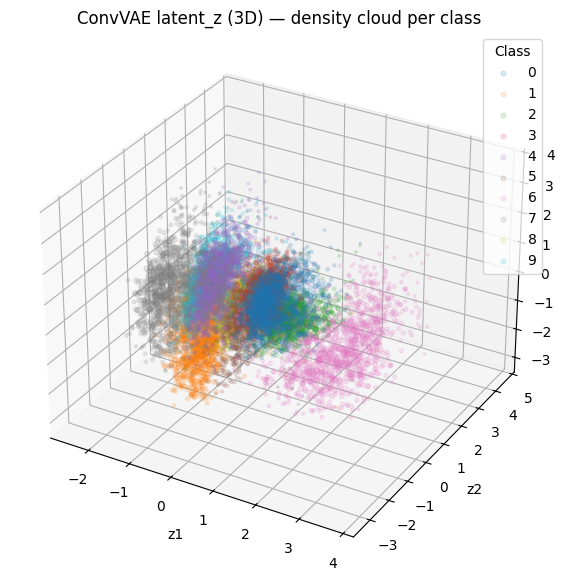

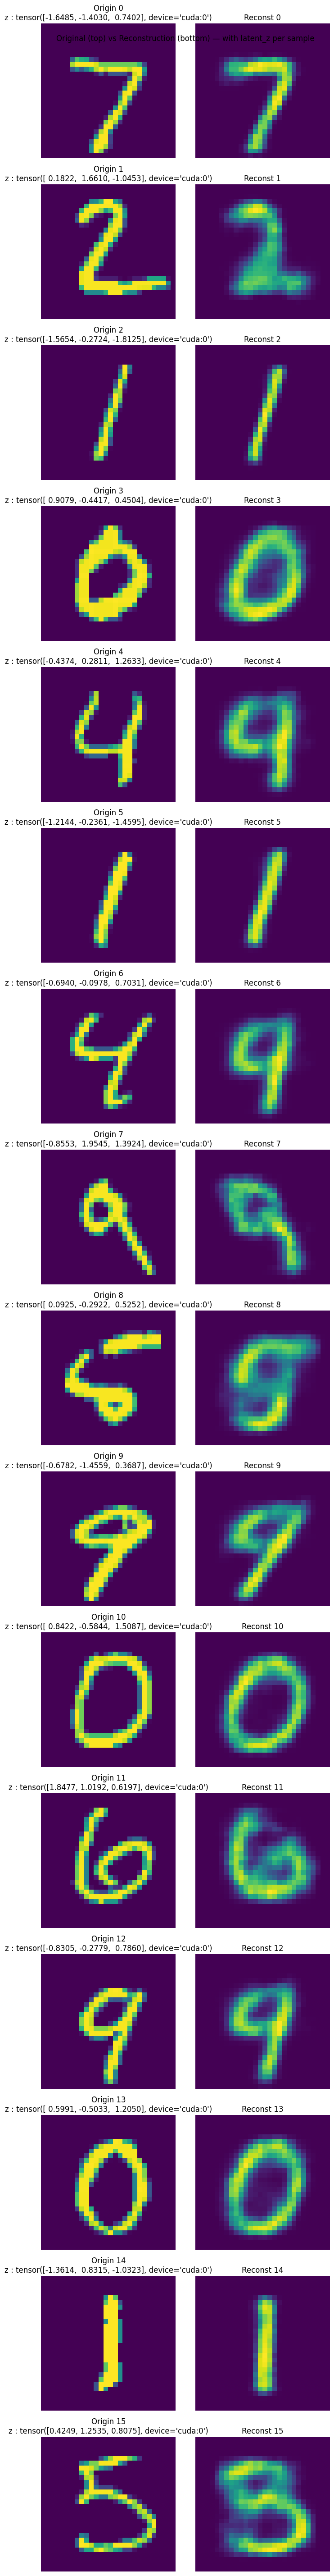

In [11]:
# VAE visualization
visualize_vae_cloud(vae_model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

### 6. 과제

위에서 3D plot으로 확인한 VAE의 latent vector들의 분포를 참고하여,

0 ~ 9의 표현을 갖는 latent vector를 설정하여 vae_model의 decoder를 freeze하고,

0 ~ 9까지의 이미지를 생성해보세요.

결과로 나오는 plot을 모두 저장해서 과제로 제출해주세요!

torch.Size([10, 3])


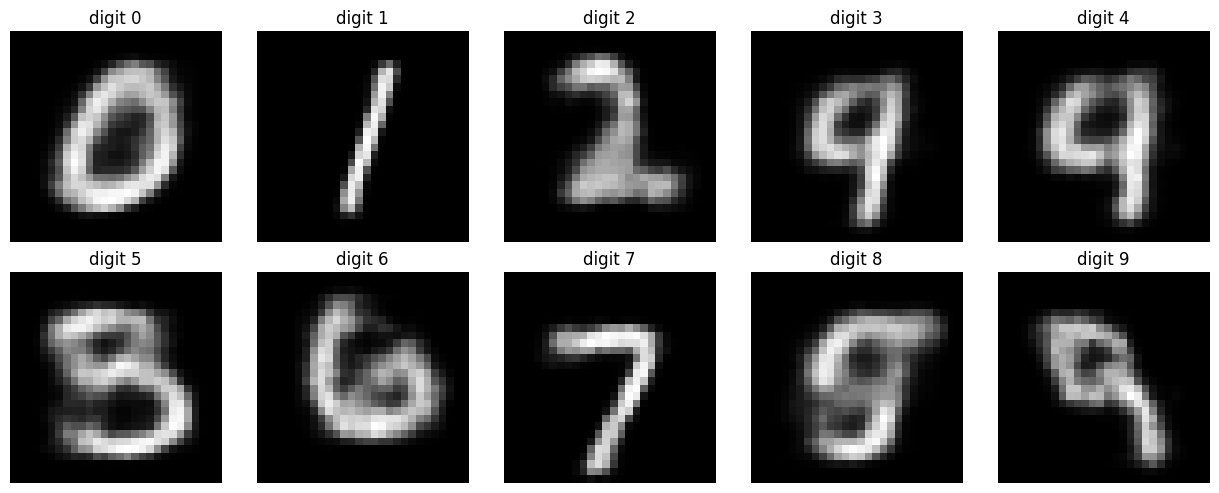

In [12]:
# TODO : Find out latent vector of 0 ~ 9
# HINT : Latent Vector must be (1, latent_dim) tensor

latent_vec_0 = torch.tensor([[0.9079, -0.4417, 0.4504]], dtype=torch.float32)
latent_vec_1 = torch.tensor([[-1.5654, -0.2724, -1.8125]], dtype=torch.float32)
latent_vec_2 = torch.tensor([[0.1822, 1.6610, -1.0453]], dtype=torch.float32)
latent_vec_3 = torch.tensor([[-0.6940, -0.0978, 0.7031]], dtype=torch.float32)
latent_vec_4 = torch.tensor([[-0.4374, 0.2811, 1.2633]], dtype=torch.float32)
latent_vec_5 = torch.tensor([[0.4249, 1.2535, 0.8075]], dtype=torch.float32)
latent_vec_6 = torch.tensor([[1.8477, 1.0192, 0.6197]], dtype=torch.float32)
latent_vec_7 = torch.tensor([[-1.6485, -1.4030, 0.7420]], dtype=torch.float32)
latent_vec_8 = torch.tensor([[0.0925, -0.2922, 0.5252]], dtype=torch.float32)
latent_vec_9 = torch.tensor([[-0.8533, 1.9545, 1.3924]], dtype=torch.float32)


# 한 번에 돌리기 위해서 ㅎㅎ..
latent_vectors = torch.cat([latent_vec_0, latent_vec_1, latent_vec_2, latent_vec_3, latent_vec_4,
                            latent_vec_5, latent_vec_6, latent_vec_7, latent_vec_8, latent_vec_9], dim=0).to(device=config['device'], dtype=torch.float32)


print(latent_vectors.shape)
# 아시져...?
vae_model.eval()

with torch.no_grad():
    reconst_images = vae_model.decode(latent_vectors)

imgs = reconst_images.detach().cpu()

# 채널/형태에 맞춰 그리기 (C,H,W) -> (H,W) or (H,W,C)
def to_numpy(img_tensor):
    arr = img_tensor.numpy()
    # (C,H,W) -> (H,W) or (H,W,C)
    if arr.ndim == 3:
        if arr.shape[0] in (1, 3):  # C=1 or C=3
            arr = arr.transpose(1, 2, 0)
        # 단일 채널이면 (H,W)
        if arr.shape[-1] == 1:
            arr = arr[:, :, 0]
    # 값 범위 보정
    arr = arr.clip(0.0, 1.0)
    return arr

# 10장을 2x5 그리드로 표시
n = imgs.size(0)
cols = 5
rows = (n + cols - 1) // cols

plt.figure(figsize=(2.5*cols, 2.5*rows))
for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.imshow(to_numpy(imgs[i]), cmap='gray')  # 컬러면 cmap 인자 제거
    plt.title(f"digit {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()